In [46]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [47]:
font_size = 13
figsize = (6, 3)
rcParams = {
    "font.size": font_size,
    "font.family": "serif",
    "font.serif": "Times New Roman",
}
sns.set_theme(context="notebook", style="whitegrid", palette="colorblind", rc=rcParams)

In [48]:
def read_pacing_metrics(path: str, subdir: str = "summary") -> pd.DataFrame:
    metrics_df = pd.read_csv(f"{path}/{subdir}/metrics.csv")
    config_df = pd.read_csv(f"{path}/{subdir}/config.csv")
    df = pd.merge(metrics_df, config_df, on="run_name")
    return df


def filter_relevant_runs(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df["curriculum"].notnull()]
    df = df[~df["curriculum.scoring"].str.contains("\+")]
    df = df[~df["run_name"].str.contains("-S\d")]
    return df


def select_baseline_runs(df: pd.DataFrame, dataset: str) -> pd.DataFrame:
    df = df[~df["curriculum"].notnull()]
    df = df[df["model"] == "EfficientNet-B0"]
    optim = "Adam" if dataset == "cifar" else "SAM-SGD-M9"
    lr = 0.001 if dataset == "cifar" else 0.01
    df = df[(df["optimizer"] == optim) & (df["learning_rate"] == lr)]
    return df


def group_cl_pacing(df: pd.DataFrame) -> pd.DataFrame:
    def _assign_ordering_type(row) -> str:
        if row["curriculum"] == "AntiCurriculum":
            return "ACL"
        if row["curriculum.scoring.type"] == "Random":
            return "RCL"
        return "CL"

    df["ordering_type"] = df.apply(_assign_ordering_type, axis=1)

    return (
        df[["ordering_type", "curriculum.pacing", "test_accuracy"]]
        .groupby(["ordering_type", "curriculum.pacing"])
        .mean()
        .reindex(["CL", "RCL", "ACL"], level=0)
        .reindex(["Logarithmic", "Root", "Linear", "Exponential"], level=1)
    )


def map_short_pacing_name(pacing: str) -> str:
    return {
        "Logarithmic": "Log",
        "Root": "Root",
        "Linear": "Linear",
        "Exponential": "Exp",
    }[pacing]


def create_pacing_performance(path: str) -> pd.DataFrame:
    df = read_pacing_metrics(path)
    df = filter_relevant_runs(df)
    df = group_cl_pacing(df)
    df.reset_index(inplace=True)
    df["curriculum.pacing"] = df["curriculum.pacing"].apply(map_short_pacing_name)
    return df


def get_baseline_accuracy(path: str, average: str = "mean") -> float:
    df = read_pacing_metrics(path)
    df = select_baseline_runs(df, "cifar" if "cifar" in path else "dcase")
    if average == "best":
        return df["test_accuracy"].max()
    else:
        return df["test_accuracy"].mean()

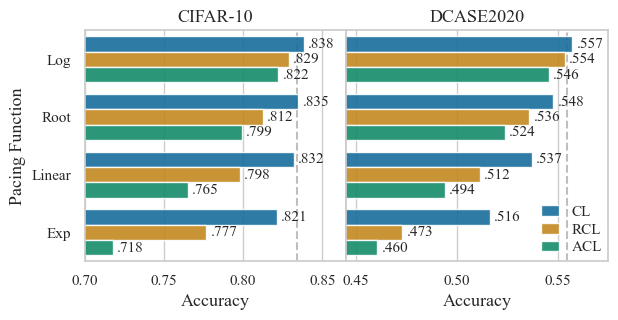

In [49]:
os.makedirs("results/tables", exist_ok=True)
cifar_df = create_pacing_performance("results/cifar")
cifar_bl = get_baseline_accuracy("results/cifar")
dcase_df = create_pacing_performance("results/dcase")
dcase_bl = get_baseline_accuracy("results/dcase")
cifar_df.to_csv("results/tables/4_c_1_ordering_pacing_cifar.csv", index=False)
dcase_df.to_csv("results/tables/4_c_1_ordering_pacing_dcase.csv", index=False)

os.makedirs("results/figures", exist_ok=True)
fig = plt.figure(figsize=figsize)
for i, (df, bl) in enumerate(zip([cifar_df, dcase_df], [cifar_bl, dcase_bl])):
    ax = fig.add_subplot(1, 2, i + 1)

    ax.axvline(x=bl, color="gray", linestyle="--", linewidth=1.5, alpha=0.5, zorder=0)

    sns.barplot(
        data=df,
        y="curriculum.pacing",
        x="test_accuracy",
        hue="ordering_type",
        ax=ax,
        alpha=0.9,
        palette="colorblind",
    )
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt=lambda x: f"{x:.3f}".lstrip("0"),
            label_type="edge",
            padding=3,
            fontsize=font_size - 2,
        )

    ax.set_title("CIFAR-10" if i == 0 else "DCASE2020", fontsize=font_size)
    ax.set_xlabel("Accuracy", fontsize=font_size)
    ax.set_ylabel("Pacing Function", fontsize=font_size)
    ax.get_legend().remove()

    plt.xlim(left=0.7, right=0.865)
    if i == 1:
        ax.set_ylabel("")
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.xlim(left=0.445, right=0.575)
        # plt.xlim(left=0.445, right=0.586)
        plt.legend(
            title=None,
            frameon=False,
            loc="lower right",
            bbox_to_anchor=(1.03, -0.03),
            handlelength=1.2,
            fontsize=font_size - 2,
            labelspacing=0.25,
        )

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0)
plt.savefig("results/figures/4_c_1_ordering_pacing.pdf", dpi=300)